# Forecasting daily minimum temperature using deep learning model
This project  you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs and  Convolutional layers to improve the model's performance.

Let's get started!

In [ ]:
#import required libs. Install them if required
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [ ]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data


In [ ]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:
        read=csv.reader(csvfile,delimiter=',')
        next(read)
        for row in read:
            times.append((row[0]))
            temperatures.append(float(row[1]))


    return times, temperatures

The next cell  uses your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

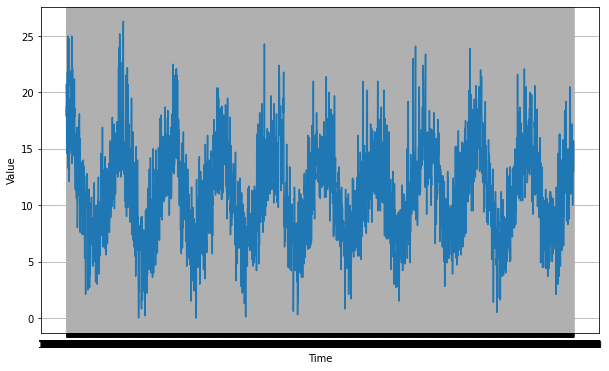

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset`

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture



In [ ]:
def create_uncompiled_model():


    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=60,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
       tf.keras.layers.LSTM(60, return_sequences=True),
          tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x *400)
    ])


    return model

In [ ]:
# Test  uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):

    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate
we can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model.

In [ ]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))


    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD()

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])


    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 8s 62ms/step - loss: 16.4684 - mae: 16.9505 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 5s 61ms/step - loss: 1.9162 - mae: 2.3723 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 5s 61ms/step - loss: 1.8356 - mae: 2.2876 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 5s 61ms/step - loss: 1.8013 - mae: 2.2539 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 5s 61ms/step - loss: 1.7302 - mae: 2.1789 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 5s 63ms/step - loss: 1.8798 - mae: 2.3330 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 5s 61ms/step - loss: 1.8280 - mae: 2.2808 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 5s 61ms/step - loss: 1.8132 - mae: 2.2651 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 5s 61ms/step - loss: 1.6426 - mae: 2.0904 - lr: 2

(0.0001, 10.0, 0.0, 10.0)

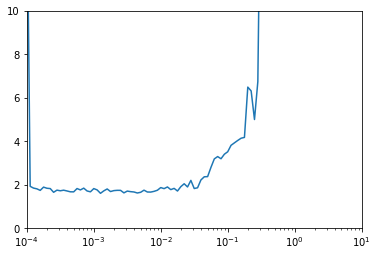

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [ ]:
def create_modelDaily Minimum Temperatures:


    model = create_uncompiled_model()


    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=.9),
                  metrics=["mse"])



    return model

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=150)

Epoch 1/150
77/77 [==============================] - 12s 113ms/step - loss: 3.7767 - mse: 35.7136
Epoch 2/150
77/77 [==============================] - 8s 101ms/step - loss: 2.5375 - mse: 14.2633
Epoch 3/150
77/77 [==============================] - 8s 103ms/step - loss: 2.9223 - mse: 17.7921
Epoch 4/150
77/77 [==============================] - 8s 97ms/step - loss: 3.1565 - mse: 21.2672
Epoch 5/150
77/77 [==============================] - 8s 98ms/step - loss: 2.1042 - mse: 10.6518
Epoch 6/150
77/77 [==============================] - 8s 102ms/step - loss: 1.9629 - mse: 9.3325
Epoch 7/150
77/77 [==============================] - 7s 96ms/step - loss: 2.1425 - mse: 10.7688
Epoch 8/150
77/77 [==============================] - 7s 95ms/step - loss: 2.0851 - mse: 10.2955
Epoch 9/150
77/77 [==============================] - 7s 92ms/step - loss: 1.8644 - mse: 8.6741
Epoch 10/150
77/77 [==============================] - 7s 88ms/step - loss: 1.8154 - mse: 8.3559
Epoch 11/150
77/77 [=================

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast.

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts



In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
rnn_forecast

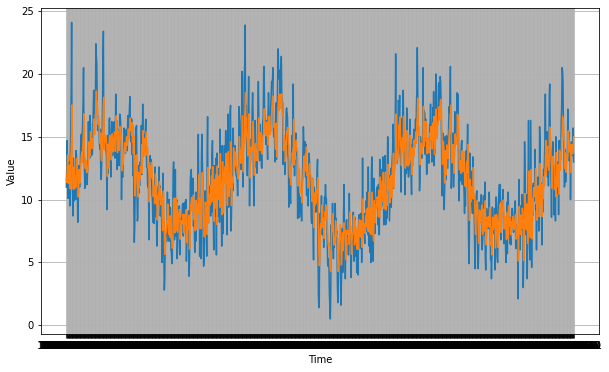

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.18, mae: 1.77 for forecast
